# Time Series Analysis and Forecasting with Prophet

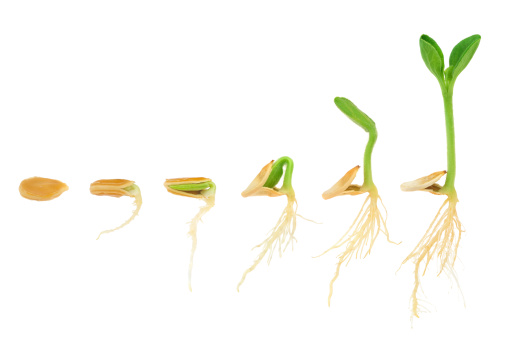

## Table of Contents

* Data Preprocessing
* Data Visualization
* Statistical Analysis (Augmented Dicky Fuller Test and ARIMA)
* Model Fitting
* Data Forecasting with Prophet

In [1]:
# Import modules

import pandas as pd
import numpy as np
import prophet

In [2]:
df = pd.read_csv("/kaggle/input/ts-energyconsumption/AEP_hourly.csv")

In [3]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [4]:
df.shape

(121273, 2)

## Data Preprocessing

In [5]:
# Check datatype of Datetime column

df.Datetime.dtype

dtype('O')

In [6]:
# Convert Datetime to datetime data type

df['Datetime'] = pd.to_datetime(df['Datetime'], format="%Y-%m-%d %H:%M:%S")

In [7]:
df.Datetime.dtype

dtype('<M8[ns]')

In [8]:
df['year'] = df.Datetime.dt.year
df['month'] = df.Datetime.dt.month
df['day'] = df.Datetime.dt.day
df['time'] = df.Datetime.dt.time

In [9]:
df.head()

,Datetime,AEP_MW,year,month,day,time
0,2004-12-31 01:00:00,13478.0,2004,12,31,01:00:00
1,2004-12-31 02:00:00,12865.0,2004,12,31,02:00:00
2,2004-12-31 03:00:00,12577.0,2004,12,31,03:00:00
3,2004-12-31 04:00:00,12517.0,2004,12,31,04:00:00
4,2004-12-31 05:00:00,12670.0,2004,12,31,05:00:00


In [10]:
df.isna().sum()

Datetime    0
AEP_MW      0
year        0
month       0
day         0
time        0
dtype: int64

## Data Visualization

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

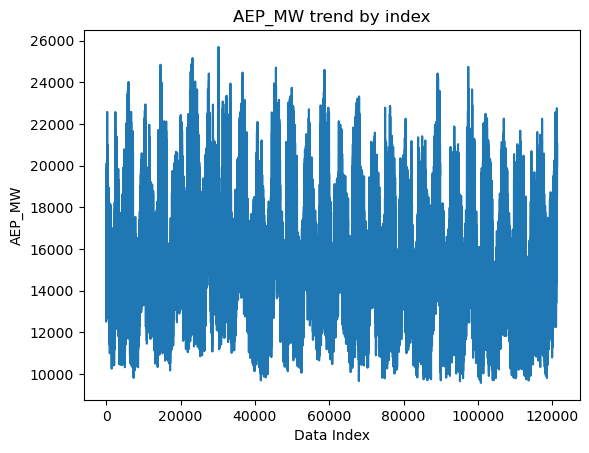

In [12]:
plt.plot(df.index, df['AEP_MW'])
plt.title("AEP_MW trend by index")
plt.xlabel("Data Index")
plt.ylabel("AEP_MW")
plt.show()

## Statistical analysis

### The Augmented Dicky Fuller Test is a statistical test that is used to determine whether or not a time series is stationary.
<i>A stationary time series is time independent while a non-stationary time series is time dependent.</i>

#### Read more about it <a href='https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html'>here</a>


In [13]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['AEP_MW'])

In [14]:
adf_result

(-16.446812104686742,
 2.399011324001994e-29,
 71,
 121201,
 {'1%': -3.430403955318047,
  '5%': -2.8615638474512295,
  '10%': -2.566782693155802},
 1743112.757904275)

In [15]:
print("The p-value is {}".format(adf_result[1]))

The p-value is 2.399011324001994e-29


### Since the p-value is less than 0.005, we reject null hypothesis. That means, that the time series is stationary (time independent).

In [16]:
df_ = df[['Datetime', 'AEP_MW']]
df_=df_.set_index('Datetime')

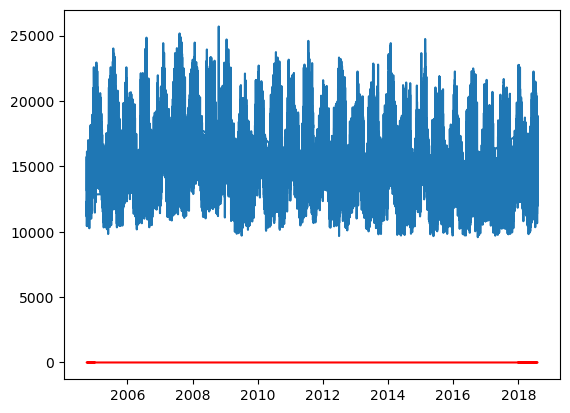

In [17]:
df_log = np.log(df_)
df_diff = df_log.diff(periods=1)
plt.plot(df_diff.index, df_.AEP_MW, '-')
plt.plot(df_diff.rolling(12).mean(), color='red')

In [18]:
df_quarterly = df_diff.resample('3M').mean()

df_daily = df_diff.resample('D').mean()

Now, let's look at the ACF (Auto-correlation function) and PACF (Partial Auto-correlation function) plots.

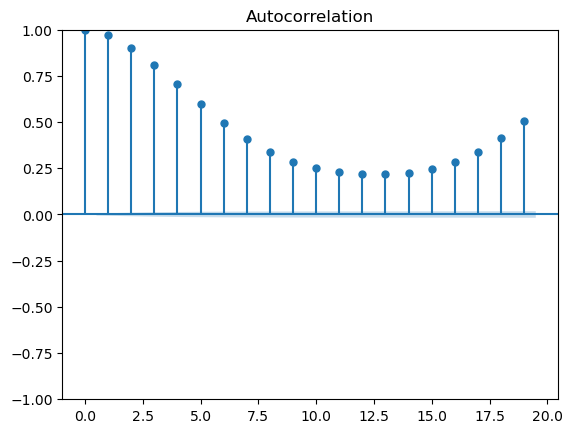

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


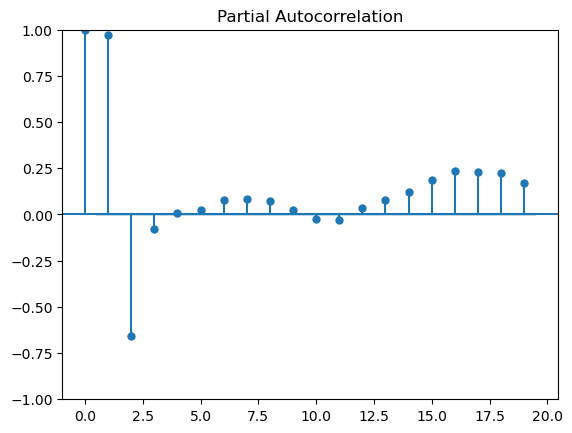

In [19]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#ACF
plot_acf(df_, lags = range(0, 20))
plt.show()
#PACF
plot_pacf(df_, lags = range(0, 20))
plt.show()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels

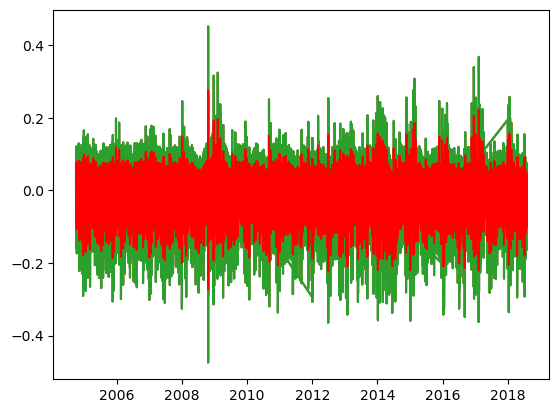

In [20]:
from statsmodels.tsa.arima.model import ARIMA
#(p,d,q)
AR_model = ARIMA(df_diff, order=(2,0,0))
AR_model_results = AR_model.fit()
plt.plot(df_diff)
plt.plot(AR_model_results.fittedvalues, color='red')

MA_model = ARIMA(df_diff, order=(0,0,2))
MA_model_results = MA_model.fit()
plt.plot(df_diff)
plt.plot(MA_model_results.fittedvalues, color='red')

ARIMA_model = ARIMA(df_diff, order=(2,0,1))
ARIMA_results = ARIMA_model.fit()
plt.plot(df_diff)
plt.plot(ARIMA_results.fittedvalues, color='red')

## Model Fitting

In [21]:
from prophet import Prophet

df_diff = df_diff[['AEP_MW']].rename(columns={"AEP_MW": 'y', "Datetime": 'ds'})

In [22]:
df_diff = df_diff.reset_index()

df_diff = df_diff.rename(columns={"Datetime": 'ds'})

In [23]:
df_diff.head()

,ds,y
0,2004-12-31 01:00:00,NaN
1,2004-12-31 02:00:00,-0.046548
2,2004-12-31 03:00:00,-0.022641
3,2004-12-31 04:00:00,-0.004782
4,2004-12-31 05:00:00,0.012149


In [24]:
model = Prophet()
model.fit(df_diff)

01:42:42 - cmdstanpy - INFO - Chain [1] start processing
01:43:05 - cmdstanpy - INFO - Chain [1] done processing


## Data Forecasting for the next 24 months

In [25]:
# Forecast the next 24 months (2 years) with prophet

future = model.make_future_dataframe(periods=24, freq='M') 
forecast = model.predict(future) 
forecast.head()
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']]

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2004-10-01 01:00:00,-0.049304,-0.087102,-0.011089,0.001006,0.001006,0.001006
1,2004-10-01 02:00:00,-0.038335,-0.076646,-0.001846,0.001006,0.001006,0.001006
2,2004-10-01 03:00:00,-0.021320,-0.059841,0.016724,0.001005,0.001005,0.001005
3,2004-10-01 04:00:00,0.000308,-0.037752,0.036156,0.001005,0.001005,0.001005
4,2004-10-01 05:00:00,0.024069,-0.012913,0.062195,0.001005,0.001005,0.001005
...,...,...,...,...,...,...,...
121288,2020-03-31 00:00:00,-0.054923,-0.095739,-0.015317,0.000069,-0.000326,0.000449
121289,2020-04-30 00:00:00,-0.054179,-0.090391,-0.016155,0.000071,-0.000358,0.000480
121290,2020-05-31 00:00:00,-0.060426,-0.096915,-0.020757,0.000072,-0.000388,0.000527
121291,2020-06-30 00:00:00,-0.055158,-0.094642,-0.017285,0.000074,-0.000416,0.000571


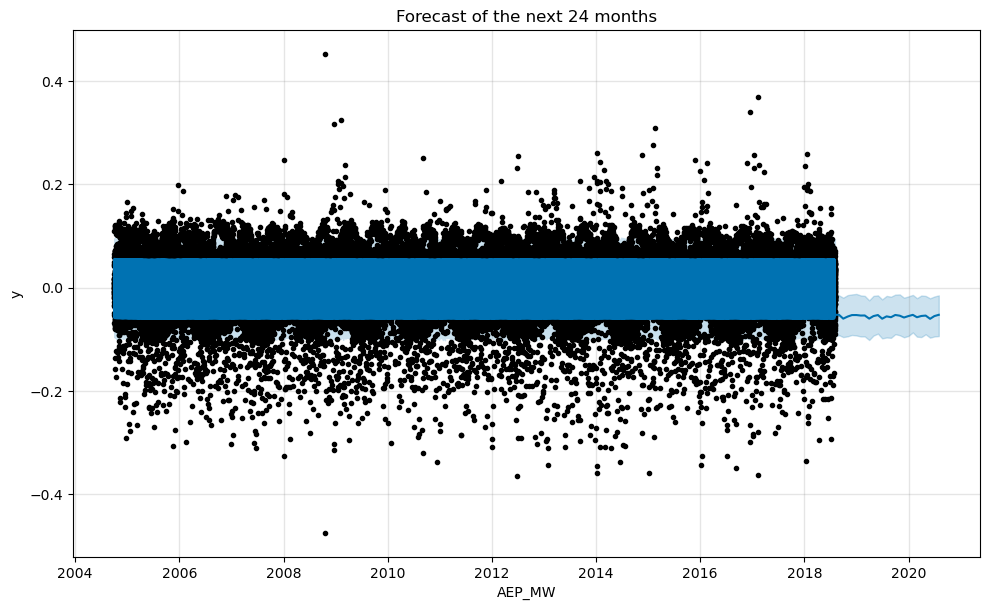

In [26]:
model.plot(forecast)
plt.title("Forecast of the next 24 months")
plt.xlabel("AEP_MW")
plt.show()

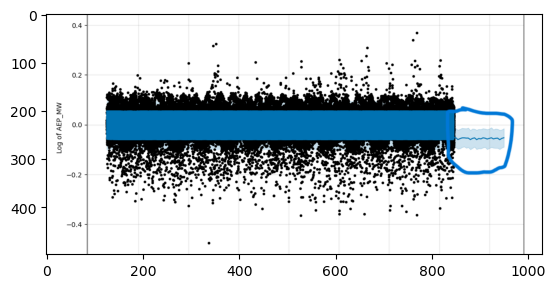

In [27]:
import matplotlib.image as image

img = image.imread("/kaggle/input/screenshot/base 24_02_2023 01_49_40.png")

plt.imshow(img)

### The blue circled region shows the forecasted part of the diagram. The remaining part of the visual is history.